[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xylem-lab/optimizing-cropland-area-est/blob/main/Notebook.ipynb)

# Integrating Map Accuracy and Sampling Efficiency for Cropland Area Estimation

Author: Adebowale Daniel Adebayo (adadebay@umd.edu)

Description:

This notebook accompanies the research paper “Integrating Map Accuracy and Sampling Efficiency for Cropland Area Estimation”. It implements unbiased stratified estimators for accuracy estimation from [Stehman (2014)](https://www.tandfonline.com/doi/full/10.1080/01431161.2014.930207), relative efficiency of maps [Skakun (2025)](https://www.sciencedirect.com/science/article/pii/S0034425725002093) and a stratified estimator [Olofsson et al. (2014)](https://www.sciencedirect.com/science/article/pii/S0034425714000704) to improve precision of cropland area estimates.

Use [Harvest crop-mask - compare_cover module](https://github.com/nasaharvest/crop-mask/blob/master/src/compare_covermaps.py) to automate the extraction of reference sample pixel values and computation of mapped area per stratum across multiple maps and country.

## 1. Land cover maps accuracy assessment

In [67]:
import math
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
#@title Stehman stratified estimators
class StehmanStratifiedEstimators:
    """Class to calculate accuracy metrics for map evaluation.
    https://www.tandfonline.com/doi/full/10.1080/01431161.2014.930207
    """

    def __init__(self, reference_class: np.ndarray, map_class: np.ndarray,
                 stratum: np.ndarray, stratum_size: np.ndarray):
        """
        Initialize the calculator with data arrays.

        Args:
            reference_class: Reference classification data
            map_class: Map classification data
            stratum: Stratum assignments for each pixel
            stratum_size: Size of each stratum
        """
        self.reference_class = reference_class
        self.map_class = map_class
        self.stratum = stratum
        self.stratum_size = stratum_size
        self.sample_size = pd.Series(stratum).value_counts().values

    def get_indicators(self, target_class: int = 1) -> pd.DataFrame:
        """
        Calculate indicator variables for accuracy assessment.

        Args:
            target_class: Target class to evaluate (default: 1 for crop)

        Returns:
            DataFrame with indicator variables for each pixel
        """
        # Overall accuracy indicator
        oa_yu = np.where(self.reference_class == self.map_class, 1, 0)

        # Area proportion indicator
        area_yu = np.where(self.reference_class == target_class, 1, 0)

        # User's accuracy indicators
        ua_yu = np.where((self.reference_class == self.map_class) &
                        (self.reference_class == target_class), 1, 0)
        ua_xu = np.where(self.map_class == target_class, 1, 0)

        # Producer's accuracy indicators
        pa_yu = np.where((self.reference_class == self.map_class) &
                        (self.reference_class == target_class), 1, 0)
        pa_xu = np.where(self.reference_class == target_class, 1, 0)

        return pd.DataFrame({
            'stratum': self.stratum,
            'oa_yu': oa_yu,
            'area_prop': area_yu,
            'ua_yu': ua_yu,
            'ua_xu': ua_xu,
            'pa_yu': pa_yu,
            'pa_xu': pa_xu
        })

    def _get_summary_stats(self, data: pd.DataFrame) -> tuple:
        """
        Calculate summary statistics for each stratum.

        Args:
            data: DataFrame with indicator variables

        Returns:
            Tuple of (mean, variance, UA covariance, PA covariance)
        """
        mean = data.groupby('stratum').mean()
        var = data.groupby('stratum').var()

        # Calculate covariances
        cov = data.groupby('stratum').cov()
        cov_ua = cov.loc[(slice(None), 'ua_yu'), 'ua_xu'].values
        cov_pa = cov.loc[(slice(None), 'pa_yu'), 'pa_xu'].values

        return mean, var, cov_ua, cov_pa

    def _calculate_ratio_accuracy(self, mean: pd.DataFrame, y_col: str, x_col: str) -> float:
        """
        Calculate ratio-based accuracy (user's or producer's accuracy).

        Args:
            mean: Mean values by stratum
            y_col: Numerator column name
            x_col: Denominator column name

        Returns:
            Calculated accuracy ratio
        """
        y_hat = mean[y_col] * self.stratum_size
        x_hat = mean[x_col] * self.stratum_size
        return y_hat.sum() / x_hat.sum()

    def calculate_user_accuracy(self, mean: pd.DataFrame) -> float:
        """Calculate user's accuracy (precision)."""
        return self._calculate_ratio_accuracy(mean, 'ua_yu', 'ua_xu')

    def calculate_producer_accuracy(self, mean: pd.DataFrame) -> float:
        """Calculate producer's accuracy (recall)."""
        return self._calculate_ratio_accuracy(mean, 'pa_yu', 'pa_xu')

    def calculate_overall_accuracy(self, mean: pd.DataFrame) -> float:
        """Calculate overall accuracy."""
        y_hat = mean['oa_yu'] * self.stratum_size
        return y_hat.sum() / self.stratum_size.sum()

    def calculate_area_proportion(self, mean: pd.DataFrame) -> float:
        """Calculate area proportion."""
        y_hat = mean['area_prop'] * self.stratum_size
        return y_hat.sum() / self.stratum_size.sum()

    def _calculate_standard_error(self, var: pd.DataFrame, mean: pd.DataFrame,
                                cov: np.ndarray, y_col: str, x_col: str,
                                accuracy_value: float = None) -> float:
        """
        Calculate standard error for accuracy metrics.

        Args:
            var: Variance values by stratum
            mean: Mean values by stratum
            cov: Covariance values
            y_col: Numerator column name
            x_col: Denominator column name
            accuracy_value: Pre-calculated accuracy value (for ratio metrics)

        Returns:
            Standard error value
        """
        if accuracy_value is None:
            # For non-ratio metrics (overall accuracy, area proportion)
            lhs = 1 / self.stratum_size.sum() ** 2
            rhs = (var[y_col] / self.sample_size * self.stratum_size ** 2).sum()
            return np.sqrt(rhs * lhs)
        else:
            # For ratio metrics (user's/producer's accuracy)
            x_hat = sum(mean[x_col] * self.stratum_size)
            lhs = 1 / x_hat ** 2
            rhs = sum(self.stratum_size ** 2 *
                     (var[y_col] + accuracy_value ** 2 * var[x_col] -
                      2 * accuracy_value * cov) / self.sample_size)
            return np.sqrt(rhs * lhs)

    def calculate_standard_errors(self, var: pd.DataFrame, mean: pd.DataFrame,
                                cov_ua: np.ndarray, cov_pa: np.ndarray,
                                ua: float, pa: float) -> dict:
        """
        Calculate all standard errors.

        Args:
            var: Variance values by stratum
            mean: Mean values by stratum
            cov_ua: UA covariance values
            cov_pa: PA covariance values
            ua: User's accuracy value
            pa: Producer's accuracy value

        Returns:
            Dictionary of standard errors
        """
        return {
            'ua_se': self._calculate_standard_error(var, mean, cov_ua, 'ua_yu', 'ua_xu', ua),
            'pa_se': self._calculate_standard_error(var, mean, cov_pa, 'pa_yu', 'pa_xu', pa),
            'oa_se': self._calculate_standard_error(var, mean, None, 'oa_yu', None),
            'area_se': self._calculate_standard_error(var, mean, None, 'area_prop', None)
        }

    def compute_f1_standard_error(self, recall: float, precision: float,
                                std_recall: float, std_precision: float) -> float:
        """
        Calculate F1 score standard error using error propagation.

        Args:
            recall: Recall value (producer's accuracy)
            precision: Precision value (user's accuracy)
            std_recall: Standard deviation of recall
            std_precision: Standard deviation of precision

        Returns:
            Standard deviation of F1 score
        """
        term1 = 2 * (recall * std_precision + precision * std_recall) / (precision + recall)
        term2 = (2 * precision * recall * (std_precision + std_recall)) / ((precision + recall) ** 2)
        return term1 + term2

    def generate_report(self, dataset_name: str, country: str) -> pd.DataFrame:
        """
        Generate comprehensive accuracy report.

        Args:
            dataset_name: Name of the dataset
            country: Country being evaluated

        Returns:
            DataFrame with all accuracy metrics and standard errors
        """
        # Calculate crop class metrics
        crop_indicators = self.get_indicators(target_class=1)
        crop_mean, crop_var, crop_cov_ua, crop_cov_pa = self._get_summary_stats(crop_indicators)

        ua = self.calculate_user_accuracy(crop_mean)
        pa = self.calculate_producer_accuracy(crop_mean)
        oa = self.calculate_overall_accuracy(crop_mean)
        area_prop = self.calculate_area_proportion(crop_mean)

        # Calculate standard errors
        se_dict = self.calculate_standard_errors(crop_var, crop_mean,
                                               crop_cov_ua, crop_cov_pa, ua, pa)

        # Calculate F1 score and its standard error
        f1_score = 2 * (ua * pa) / (ua + pa)
        f1_se = self.compute_f1_standard_error(pa, ua, se_dict['pa_se'], se_dict['ua_se'])

        # Calculate non-crop class metrics
        nc_indicators = self.get_indicators(target_class=0)
        nc_mean, nc_var, nc_cov_ua, nc_cov_pa = self._get_summary_stats(nc_indicators)
        return pd.DataFrame({
            'dataset': dataset_name,
            'country': country,
            'crop_ua': ua,
            'crop_ua_se': se_dict['ua_se'],
            'crop_pa': pa,
            'crop_pa_se': se_dict['pa_se'],
            'oa': oa,
            'oa_se': se_dict['oa_se'],
            'crop_f1_score': f1_score,
            'crop_f1_score_se': f1_se,
            'non_crop_ua': self.calculate_user_accuracy(nc_mean),
            'non_crop_pa': self.calculate_producer_accuracy(nc_mean),
            'non_crop_ua_se': self._calculate_standard_error(nc_var, nc_mean,
                                                                      nc_cov_ua, 'ua_yu', 'ua_xu'),
            'non_crop_pa_se': self._calculate_standard_error(nc_var, nc_mean,
                                                                           nc_cov_pa, 'pa_yu', 'pa_xu'),
            'crop_area_proportion': area_prop,
            'crop_area_proportion_se': se_dict['area_se'],

        }, index=[0])


In [69]:
countries = ['Kenya', 'Rwanda', 'Malawi', 'Tanzania', 'Uganda', 'Zambia']
datasets = ['copernicus','glad','gflfc30','dynamicworld','digital-earth-africa','esri-lulc']

In [70]:
extracted_df = pd.read_csv('./data/reference_sample_pixel_values.csv')
extracted_df.head()
# replace United Republic of Tanzania with Tanzania
extracted_df['country'] = extracted_df['country'].replace('United Republic of Tanzania', 'Tanzania')

In [71]:
area_df = pd.read_csv('./data/binary_mapped_area.csv')
area_df = area_df[area_df['dataset'] == 'harvest-dev']

a_j = {}
for (country, dataset), group in area_df.groupby(['country', 'dataset']):
    crop_area = float(group['crop_area'].values[0])
    noncrop_area = float(group['noncrop_area'].values[0])
    if country not in a_j:
        a_j[country] = {}
    a_j[country][dataset] = np.array([noncrop_area, crop_area])

In [72]:
a_j

{'Kenya': {'harvest-dev': array([5.39625758e+09, 4.50603161e+08])},
 'Malawi': {'harvest-dev': array([7.77295117e+08, 4.50204730e+08])},
 'Rwanda': {'harvest-dev': array([27828097., 23822713.])},
 'Tanzania': {'harvest-dev': array([7.53529672e+09, 1.97564009e+09])},
 'Uganda': {'harvest-dev': array([1.87193389e+09, 5.60585942e+08])},
 'Zambia': {'harvest-dev': array([7.24791054e+09, 5.27083094e+08])}}

In [73]:
metric_performance = []
for country in countries:
    country_data = extracted_df[extracted_df['country'] == country]
    for dataset in datasets:
        metric = StehmanStratifiedEstimators(
            reference_class=country_data['binary'].values,
            map_class=country_data[dataset].values,
            stratum=country_data['stratum'].values,
            stratum_size=a_j[country]['harvest-dev']
        ).generate_report(dataset_name=dataset, country=country)
        metric_performance.append(metric)

metric_performance = pd.concat(metric_performance, ignore_index=True).set_index('dataset')


In [74]:
metric_performance.head()

,country,crop_ua,crop_ua_se,crop_pa,crop_pa_se,oa,oa_se,crop_f1_score,crop_f1_score_se,non_crop_ua,non_crop_pa,non_crop_ua_se,non_crop_pa_se,crop_area_proportion,crop_area_proportion_se
dataset,,,,,,,,,,,,,,,
copernicus,Kenya,0.419398,0.061481,0.694711,0.073088,0.891327,0.015505,0.523038,0.194877,0.969479,0.909773,0.018110,0.018110,0.08577,0.012792
glad,Kenya,0.575224,0.073823,0.630479,0.078253,0.928374,0.012751,0.601585,0.227751,0.965018,0.956321,0.015497,0.015497,0.08577,0.012792
gflfc30,Kenya,0.372770,0.074342,0.375961,0.073734,0.892218,0.014894,0.374359,0.222116,0.941408,0.940652,0.016348,0.016348,0.08577,0.012792
dynamicworld,Kenya,0.248832,0.051960,0.467115,0.077493,0.833349,0.020235,0.324698,0.180378,0.945523,0.867708,0.021497,0.021497,0.08577,0.012792
digital-earth-africa,Kenya,0.398103,0.059362,0.650670,0.078634,0.885661,0.016360,0.493975,0.198352,0.965153,0.907707,0.018348,0.018348,0.08577,0.012792


In [75]:
def get_ensemble_metrics(country, results_df, combined_df, a_j):
    """Calculate ensemble metrics for a given country.

    Args:
        country (str): Country name
        results_df (pd.DataFrame): Results dataframe filtered for country
        combined_df (pd.DataFrame): Combined dataframe with all data
        a_j (dict): Dictionary with stratum sizes

    Returns:
        pd.DataFrame: Ensemble metrics for the country
    """
    # Get all available datasets for ensemble
    ensemble_maps = list(results_df.reset_index()['dataset'])
    temp = combined_df[combined_df['country'] == country].copy()

    # Calculate ensemble prediction using mode across all datasets
    temp['ensemble'] = temp[ensemble_maps].mode(axis=1)[0]

    # Calculate ensemble metrics
    ensemble = StehmanStratifiedEstimators(
        reference_class=temp['binary'].values,
        map_class=temp['ensemble'].values,
        stratum=temp['stratum'].values,
        stratum_size=a_j[country]['harvest-dev']
    ).generate_report(dataset_name='ensemble', country=country)
    return ensemble

ensemble_metrics = []
for country in countries:
    metrics = get_ensemble_metrics(country, metric_performance, extracted_df, a_j)
    ensemble_metrics.append(metrics)

ensemble_results = pd.concat(ensemble_metrics, ignore_index=True).set_index('dataset')
result_combined = pd.concat([metric_performance, ensemble_results])

datasets = datasets + ['ensemble']

In [76]:
result_combined.head()

,country,crop_ua,crop_ua_se,crop_pa,crop_pa_se,oa,oa_se,crop_f1_score,crop_f1_score_se,non_crop_ua,non_crop_pa,non_crop_ua_se,non_crop_pa_se,crop_area_proportion,crop_area_proportion_se
dataset,,,,,,,,,,,,,,,
copernicus,Kenya,0.419398,0.061481,0.694711,0.073088,0.891327,0.015505,0.523038,0.194877,0.969479,0.909773,0.018110,0.018110,0.08577,0.012792
glad,Kenya,0.575224,0.073823,0.630479,0.078253,0.928374,0.012751,0.601585,0.227751,0.965018,0.956321,0.015497,0.015497,0.08577,0.012792
gflfc30,Kenya,0.372770,0.074342,0.375961,0.073734,0.892218,0.014894,0.374359,0.222116,0.941408,0.940652,0.016348,0.016348,0.08577,0.012792
dynamicworld,Kenya,0.248832,0.051960,0.467115,0.077493,0.833349,0.020235,0.324698,0.180378,0.945523,0.867708,0.021497,0.021497,0.08577,0.012792
digital-earth-africa,Kenya,0.398103,0.059362,0.650670,0.078634,0.885661,0.016360,0.493975,0.198352,0.965153,0.907707,0.018348,0.018348,0.08577,0.012792


In [77]:
result_combined.to_csv('./data/accuracy_assessment_results.csv')

#### Latex table

In [78]:
country_order = ['Kenya', 'Rwanda', 'Malawi', 'Tanzania','Uganda', 'Zambia']

map_rename = {
    'dynamicworld': 'DynamicWorld',
    'copernicus': 'Copernicus',
    'ensemble': 'Ensemble',
    'digital-earth-africa': 'DEA',
    'esri-lulc': 'Esri LULC',
    'glad': 'GLAD',
    'gflfc30': 'GLCFCS30'}

map_order = ['Ensemble', 'DEA', 'GLAD', 'Esri LULC', 'DynamicWorld', 'GLCFCS30', 'Copernicus']

In [79]:
result_combined.columns

Index(['country', 'crop_ua', 'crop_ua_se', 'crop_pa', 'crop_pa_se', 'oa',
       'oa_se', 'crop_f1_score', 'crop_f1_score_se', 'non_crop_ua',
       'non_crop_pa', 'non_crop_ua_se', 'non_crop_pa_se',
       'crop_area_proportion', 'crop_area_proportion_se'],
      dtype='object')

In [80]:
df = result_combined.copy()
df.reset_index(inplace=True)

# remove any whitespaces
df.columns = df.columns.str.strip()

#select only important columns
df = df[['country', 'dataset', 'crop_f1_score', 'crop_f1_score_se', 'oa', 'oa_se', 'crop_pa', 'crop_pa_se', 'crop_ua', 'crop_ua_se']].copy()
# df.rename(columns={'f1_score': 'F1 Score', 'std_f1_score': 'std_F1', 'accuracy': 'OA', 'std_acc': 'std_OA', 'crop_recall_pa': 'Recall (PA)', 'std_crop_pa': 'std_PA', 'crop_precision_ua': 'Precision (UA)', 'std_crop_ua': 'std_UA'}, inplace=True)
df.rename(columns={'crop_f1_score': 'F1 Score', 'oa': 'OA', 'crop_pa': 'Recall (PA)', 'crop_ua': 'Precision (UA)'}, inplace=True)

df['dataset'] = df['dataset'].replace(map_rename)
df['country'] = pd.Categorical(df['country'], categories=country_order, ordered=True)
df['dataset'] = pd.Categorical(df['dataset'], categories=map_order, ordered=True)
df = df.sort_values(by=['country','dataset'], ascending=[True, True])
df.head()

,country,dataset,F1 Score,crop_f1_score_se,OA,oa_se,Recall (PA),crop_pa_se,Precision (UA),crop_ua_se
36,Kenya,Ensemble,0.554739,0.238932,0.930839,0.012358,0.502305,0.077559,0.619396,0.082667
4,Kenya,DEA,0.493975,0.198352,0.885661,0.016360,0.650670,0.078634,0.398103,0.059362
1,Kenya,GLAD,0.601585,0.227751,0.928374,0.012751,0.630479,0.078253,0.575224,0.073823
5,Kenya,Esri LULC,0.603200,0.235744,0.934171,0.011944,0.583364,0.077660,0.624433,0.079607
3,Kenya,DynamicWorld,0.324698,0.180378,0.833349,0.020235,0.467115,0.077493,0.248832,0.051960


In [81]:
#@title Result - Latex Table
latex_table = """
\\begin{table}[!htp]
\\tiny
\\centering
\\begin{tabular}{llllllllll}
\\toprule
Country & Metric & Ensemble & DEA & GLAD & Esri LULC & DynamicWorld & GLCFCS30 & Copernicus & Mean \\\\ \\hline
"""

for country in country_order:
    df_country = df[df['country'] == country]

    latex_table += f"\\multirow{{4}}{{*}}{{{country}}}"

    for idx, (metric, err) in enumerate([('Precision (UA)', 'crop_pa_se'), ('Recall (PA)', 'crop_ua_se'), ('F1 Score', 'crop_f1_score_se'), ('OA', 'oa_se')]):
            latex_table += f" & {metric} "

            metric_values = []

            for mapname in map_order:
                map_df = df_country[df_country['dataset'] == mapname]

                if not map_df.empty:
                    rank = df_country[metric].sort_values(ascending=False).unique()
                    value = map_df[metric].values[0]
                    error = map_df[err].values[0]

                    metric_values.append(value)

                    if value == rank[0]:
                        latex_table += f"& \\color{{blue}}\\textbf{{{value:.3f}$\\pm${error:.2f}}} "
                    elif len(rank) > 1 and value == rank[1]:
                        latex_table += f"& \\textbf{{{value:.3f}$\\pm${error:.2f}}} "
                    else:
                        latex_table += f"& {value:.3f}$\\pm${error:.2f} "
                else:
                    latex_table += "& - "

            avg = np.mean(metric_values)
            std = np.std(metric_values)
            latex_table += f"& {avg:.3f}$\\pm${std:.2f} \\\\ \n"

    latex_table += "\\midrule\n"

latex_table += "\\multirow{4}{*}{Mean}"

for idx, (metric, err) in enumerate([('Precision (UA)', 'crop_pa_se'), ('Recall (PA)', 'crop_ua_se'), ('F1 Score', 'crop_f1_score_se'), ('OA', 'oa_se')]):

    latex_table += f" & {metric} "

    mean_values = []
    for mapname in map_order:
        map_df = df[df['dataset'] == mapname]

        if not map_df.empty:
            avg = map_df[metric].mean()
            std = map_df[err].mean()
            mean_values.append(avg)

            # Add highlighting for the mean row
            rank = df[metric].groupby(df['dataset']).mean().sort_values(ascending=False).unique()

            if avg == rank[0]:
                latex_table += f"& \\color{{blue}}\\textbf{{{avg:.3f}$\\pm${std:.2f}}} "
            elif len(rank) > 1 and avg == rank[1]:
                latex_table += f"& \\textbf{{{avg:.3f}$\\pm${std:.2f}}} "
            else:
                latex_table += f"& {avg:.3f}$\\pm${std:.2f} "
        else:
            latex_table += "& - "

    latex_table += "\\\\ \n"
latex_table += "\\bottomrule\n\\end{tabular}\n\\caption{...\\label{tab:...}}\n\\end{table}"
print(latex_table)


\begin{table}[!htp]
\tiny
\centering
\begin{tabular}{llllllllll}
\toprule
Country & Metric & Ensemble & DEA & GLAD & Esri LULC & DynamicWorld & GLCFCS30 & Copernicus & Mean \\ \hline
\multirow{4}{*}{Kenya} & Precision (UA) & \textbf{0.619$\pm$0.08} & 0.398$\pm$0.08 & 0.575$\pm$0.08 & \color{blue}\textbf{0.624$\pm$0.08} & 0.249$\pm$0.08 & 0.373$\pm$0.07 & 0.419$\pm$0.07 & 0.465$\pm$0.13 \\ 
 & Recall (PA) & 0.502$\pm$0.08 & \textbf{0.651$\pm$0.06} & 0.630$\pm$0.07 & 0.583$\pm$0.08 & 0.467$\pm$0.05 & 0.376$\pm$0.07 & \color{blue}\textbf{0.695$\pm$0.06} & 0.558$\pm$0.11 \\ 
 & F1 Score & 0.555$\pm$0.24 & 0.494$\pm$0.20 & \textbf{0.602$\pm$0.23} & \color{blue}\textbf{0.603$\pm$0.24} & 0.325$\pm$0.18 & 0.374$\pm$0.22 & 0.523$\pm$0.19 & 0.497$\pm$0.10 \\ 
 & OA & \textbf{0.931$\pm$0.01} & 0.886$\pm$0.02 & 0.928$\pm$0.01 & \color{blue}\textbf{0.934$\pm$0.01} & 0.833$\pm$0.02 & 0.892$\pm$0.01 & 0.891$\pm$0.02 & 0.899$\pm$0.03 \\ 
\midrule
\multirow{4}{*}{Rwanda} & Precision (UA) & \textbf{0.7

/tmp/ipython-input-3002742811.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rank = df[metric].groupby(df['dataset']).mean().sort_values(ascending=False).unique()


## 2. Relative efficiency and Area estimation

In [82]:
accRes = pd.read_csv('./data/accuracy_assessment_results.csv')
display(accRes.head())
countries = accRes['country'].unique()

,dataset,country,crop_ua,crop_ua_se,crop_pa,crop_pa_se,oa,oa_se,crop_f1_score,crop_f1_score_se,non_crop_ua,non_crop_pa,non_crop_ua_se,non_crop_pa_se,crop_area_proportion,crop_area_proportion_se
0,copernicus,Kenya,0.419398,0.061481,0.694711,0.073088,0.891327,0.015505,0.523038,0.194877,0.969479,0.909773,0.018110,0.018110,0.08577,0.012792
1,glad,Kenya,0.575224,0.073823,0.630479,0.078253,0.928374,0.012751,0.601585,0.227751,0.965018,0.956321,0.015497,0.015497,0.08577,0.012792
2,gflfc30,Kenya,0.372770,0.074342,0.375961,0.073734,0.892218,0.014894,0.374359,0.222116,0.941408,0.940652,0.016348,0.016348,0.08577,0.012792
3,dynamicworld,Kenya,0.248832,0.051960,0.467115,0.077493,0.833349,0.020235,0.324698,0.180378,0.945523,0.867708,0.021497,0.021497,0.08577,0.012792
4,digital-earth-africa,Kenya,0.398103,0.059362,0.650670,0.078634,0.885661,0.016360,0.493975,0.198352,0.965153,0.907707,0.018348,0.018348,0.08577,0.012792


In [83]:
# Filter data once for each country to avoid repeated filtering
results = []
for country in countries:
    country_df = accRes[accRes['country'] == country]

    for dataset in datasets:
        dataset_df = country_df[country_df['dataset'] == dataset]

        # Skip if no data for this country-dataset combination
        if dataset_df.empty:
            continue

        # Extract metrics
        metrics = {
            'country': [country],
            'dataset': [dataset],
            'user_accuracy_crop': [dataset_df['crop_ua'].values[0]],
            'producer_accuracy_crop': [dataset_df['crop_pa'].values[0]],
            'crop_area_proportion': [dataset_df['crop_area_proportion'].values[0]]
        }

        results.append(pd.DataFrame(metrics))

# Combine all results
results = pd.concat(results, ignore_index=True)

In [84]:
# read the mapped area for all countries and all datasets
area_df = pd.read_csv('./data/binary_mapped_area.csv')

a_j = {}
for (country, dataset), group in area_df.groupby(['country', 'dataset']):
    crop_area = int(group['crop_area'].values[0])
    noncrop_area = int(group['noncrop_area'].values[0])
    if country not in a_j:
        a_j[country] = {}
    a_j[country][dataset] = np.array([noncrop_area, crop_area])

In [85]:
#@title Area proportion functions
# https://github.com/nasaharvest/crop-mask/blob/master/src/area_utils.py
def compute_area_error_matrix(cm: np.ndarray, w_j: np.ndarray) -> np.ndarray:
    """Computes error matrix in terms of area proportion, p[i,j].

    Args:
        cm:
            Confusion matrix of reference and map samples expressed in terms of
            sample counts, n[i,j]. Row-column ordered reference-row, map-column.
        w_j:
            Array containing the marginal pixel area proportion of each mapped class.

    Returns:
        Error matrix of reference and map samples expressed in terms of area proportion.

    """

    n_dotj = cm.sum(axis=0)
    area_matrix = (w_j * cm) / n_dotj
    # if no predictions for class j, n_dotj will be 0
    area_matrix[np.where(np.isnan(area_matrix))] = 0
    return area_matrix

def compute_u_j(am: np.ndarray) -> np.ndarray:
    """Computes the user's accuracy of mapped classes.

    Args:
        am:
            Error matrix of reference and map samples expressed in terms of
            area proportions, p[i,j]. Row-column ordered reference-row, map-column.

    Returns:
        An array containing the user accuracy of each mapped class 'j'.

    """

    p_jjs = np.diag(am)
    p_dotjs = am.sum(axis=0)
    u_j = p_jjs / p_dotjs
    # if no predictions for class j, p_dotj will be 0
    u_j[np.where(np.isnan(u_j))] = 0
    return u_j

def compute_p_i(am: np.ndarray) -> np.ndarray:
    """Computes the producer's accuracy of reference classes.

    Args:
        am:
            Error matrix of reference and map samples expressed in terms of
            area proportions, p[i,j]. Row-column ordered reference-row, map-column.

    Returns:
        An array containing the producer's accuracy of each reference class 'i'.

    """

    p_iis = np.diag(am)
    p_idots = am.sum(axis=1)
    return p_iis / p_idots

In [86]:
#@title Relative efficiency
#__Author__: Sergii Skakum 2025: https://www.sciencedirect.com/science/article/pii/S0034425725002093

def get_params(v: float, u: float, f: float, gamma: float = 0.1) -> dict:
    """Calculate optimal sampling parameters for area estimation.

    Args:
        v: Producer's accuracy
        u: User's accuracy
        f: True proportion of area
        gamma: Target coefficient of variation (default: 0.1)

    Returns:
        Dictionary containing sampling parameters and feasibility check
    """
    # Initialize result dictionary
    res = {
        'if_feasible': True,
        'f': f,
        'f11': v * f,
        'f21': f - v * f,
        'w1': f * v / u,
        'u1': u,
        'v1': v
    }

    # Calculate remaining confusion matrix elements
    res['f12'] = res['w1'] - res['f11']
    res['f22'] = 1 - res['f11'] - res['f12'] - res['f21']
    res['w2'] = res['f21'] + res['f22']

    # Calculate class 2 accuracies with zero division protection
    res['u2'] = res['f22'] / res['w2'] if res['w2'] > 0 else 0
    res['v2'] = res['f22'] / (1 - f) if (1 - f) > 0 else 0
    res['oa'] = res['f11'] + res['f22']

    # Check feasibility
    confusion_elements = ['f11', 'f12', 'f21', 'f22']
    if any(res[k] < 0 for k in confusion_elements):
        res['if_feasible'] = False
        return res

    # Calculate optimal sample sizes
    w1_term = res['w1'] * math.sqrt(res['u1'] * (1 - res['u1']))
    w2_term = res['w2'] * math.sqrt(res['u2'] * (1 - res['u2']))

    res['n_opt_nom'] = (w1_term + w2_term)**2
    res['n_opt'] = int(round(res['n_opt_nom'] / (f * gamma)**2))

    # Neyman allocation
    res['n1_opt'] = int(round(
        res['n_opt'] * w1_term / math.sqrt(res['n_opt_nom'])
    ))
    res['n2_opt'] = res['n_opt'] - res['n1_opt']

    # Calculate variance and CV
    var_term1 = res['w1']**2 * res['u1'] * (1 - res['u1']) / (res['n1_opt'] - 1)
    var_term2 = res['w2']**2 * res['u2'] * (1 - res['u2']) / (res['n2_opt'] - 1)
    res['var_f_hat'] = var_term1 + var_term2
    res['cv_f_hat'] = np.sqrt(res['var_f_hat']) / f * 100

    return res


In [87]:
# Create dictionary to store parameters for each country-dataset combination
dict_params = {
    (country, dataset): get_params(
        v=results.loc[
            (results['country'] == country) &
            (results['dataset'] == dataset),
            'producer_accuracy_crop'
        ].values[0],
        u=results.loc[
            (results['country'] == country) &
            (results['dataset'] == dataset),
            'user_accuracy_crop'
        ].values[0],
        f=results.loc[
            (results['country'] == country) &
            (results['dataset'] == dataset),
            'crop_area_proportion'
        ].values[0]
    )
    for country in countries
    for dataset in datasets
}

# Convert dictionary to DataFrame with flattened structure
df_params = pd.DataFrame([
    {'country': country, 'dataset': dataset, **params}
    for (country, dataset), params in dict_params.items()
])

In [88]:
# Find optimal dataset for each country based on minimum n_opt
criterion = 'n_opt'
area_map_df = (
    df_params
    .groupby('country')
    .apply(lambda x: x.loc[x[criterion].idxmin()])
    .reset_index(drop=True)
    .rename(columns={'u1': 'u', 'v1': 'v'})
    [['country', 'dataset', 'n_opt', 'n1_opt', 'n2_opt', 'u', 'v', 'f', 'cv_f_hat']]
)
area_map_df

/tmp/ipython-input-68583463.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x[criterion].idxmin()])


,country,dataset,n_opt,n1_opt,n2_opt,u,v,f,cv_f_hat
0,Kenya,glad,616,134,482,0.575224,0.630479,0.085770,10.019017
1,Malawi,digital-earth-africa,288,125,163,0.471155,0.692259,0.208945,10.026851
2,Rwanda,ensemble,67,27,40,0.764418,0.595931,0.561964,10.189493
3,Tanzania,glad,239,71,168,0.666104,0.651267,0.212907,10.037695
4,Uganda,glad,146,84,62,0.587225,0.823900,0.323742,10.053500
5,Zambia,digital-earth-africa,159,68,91,0.682844,0.794195,0.257708,10.057630


In [89]:
# Read reference sample
area_ref_samples = pd.read_csv('./data/area_estimation_refrence_samples.csv')
area_ref_samples.head()

,lat,lon,geom,binary,country,map,glad,digital-earth-africa,ensemble
0,-1.868271,39.116375,POINT(39.11637547899306 -1.868271212147575),0,Kenya,0,0.0,NaN,NaN
1,3.897655,34.917291,POINT(34.91729051490477 3.897655270501986),0,Kenya,0,0.0,NaN,NaN
2,1.390457,38.337177,POINT(38.33717680154779 1.390457312524401),0,Kenya,0,0.0,NaN,NaN
3,1.245290,40.661837,POINT(40.661837093792286 1.245289562610687),0,Kenya,0,0.0,NaN,NaN
4,-1.174502,37.685359,POINT(37.68535923139066 -1.174502318222068),0,Kenya,0,0.0,NaN,NaN


In [90]:
def get_resolution(dataset):
    """Get resolution based on dataset type."""
    return 30 if dataset == 'glad' else 10

def calculate_area_metrics(country, dataset, area_map_df, area_ref_samples, a_j):
    """Calculate area metrics for a given country and dataset."""
    # Get dataset parameters
    adf = area_map_df[area_map_df['country'] == country]
    dataset_name = adf['dataset'].values[0]
    resolution = get_resolution(dataset_name)

    # Get sample sizes
    total_sample_size = adf['n_opt'].values[0]
    crop_sample_size = adf['n1_opt'].values[0]
    noncrop_sample_size = adf['n2_opt'].values[0]

    # Get reference data
    temp = area_ref_samples[area_ref_samples['country'] == country]
    true = temp['binary'].values
    pred = temp[dataset_name].values

    # Calculate area proportions
    area_props = a_j[country][dataset_name]
    a_sum = area_props.sum()
    w_j = area_props / a_sum

    # Calculate confusion matrix and error metrics
    cm = confusion_matrix(true, pred, labels=[0,1])
    am = compute_area_error_matrix(cm, w_j)
    u = compute_u_j(am)
    v = compute_p_i(am)
    f_hat = am.sum(axis=1)[1]

    # Calculate variance and CV
    var_f_hat = (w_j[1]**2 * u[1]*(1-u[1]) / (crop_sample_size - 1) +
                w_j[0]**2 * u[0]*(1-u[0]) / (noncrop_sample_size - 1))
    cv_f_hat = np.sqrt(var_f_hat) / f_hat * 100

    # Calculate area in hectares
    f_ha = (f_hat * a_sum * resolution**2 / 10000).round(0)
    var_f_ha = (var_f_hat * a_sum * resolution**2 / 10000).round(0)

    return pd.DataFrame({
        'country': [country],
        'dataset': [dataset_name],
        'n_opt': [total_sample_size],
        'n1_opt': [crop_sample_size],
        'n2_opt': [noncrop_sample_size],
        'f_hat': [f_hat],
        'f_ha': [f_ha],
        'se_ha': (np.sqrt(var_f_hat) * a_sum * resolution**2 / 10000).round(0),
        'px_ha': (area_props[1] * resolution**2 / 10000).round(0),
        'u_crop': [u[1]],
        'v_crop': [v[1]],
        'var_f_hat': [var_f_hat],
        'cv_f_hat': [cv_f_hat],
        'var_f_ha': [var_f_ha]
    })

# Calculate metrics for all countries
area_results = pd.concat([
    calculate_area_metrics(country, dataset, area_map_df, area_ref_samples, a_j)
    for country in countries
])

In [91]:
area_results

,country,dataset,n_opt,n1_opt,n2_opt,f_hat,f_ha,se_ha,px_ha,u_crop,v_crop,var_f_hat,cv_f_hat,var_f_ha
0,Kenya,glad,616,134,482,0.075078,4404865.0,425127.0,5833700.0,0.567164,0.751139,0.000053,9.651299,3080.0
0,Rwanda,ensemble,67,27,40,0.551206,1409732.0,151747.0,1158140.0,0.703704,0.578115,0.003520,10.764259,9004.0
0,Malawi,digital-earth-africa,288,125,163,0.295952,3632816.0,291724.0,3783073.0,0.616000,0.641478,0.000565,8.030243,6933.0
0,Tanzania,glad,239,71,168,0.132919,12659944.0,1608738.0,15752314.0,0.563380,0.700994,0.000285,12.707306,27172.0
0,Uganda,glad,146,84,62,0.252509,6142253.0,758802.0,5833155.0,0.741176,0.703878,0.000973,12.353813,23670.0
0,Zambia,digital-earth-africa,159,68,91,0.081128,6307961.0,925112.0,8989470.0,0.617647,0.880208,0.000142,14.665787,11007.0


## Visualization

In [92]:
#@title Plot error matrices
def plot_error_matrices(countries, area_map_df, area_ref_samples, a_j, area_proportion=True, save_path=None):
    """
    Plot error matrices for multiple countries.

    Args:
        countries (list): List of country names
        area_map_df (DataFrame): DataFrame containing map data
        area_ref_samples (DataFrame): DataFrame containing reference samples
        a_j (dict): Dictionary containing area proportions
        area_proportion (bool): Whether to plot area proportions or raw counts
        save_path (str): Path to save the figure
    """
    # Set up plot style
    plt.style.use('tableau-colorblind10')
    plt.rcParams.update({'font.size': 14})

    # Create figure and grid
    n_rows, n_cols = 2, 3
    fig = plt.figure(figsize=(11, 9), constrained_layout=True)
    gs = gridspec.GridSpec(n_rows, n_cols, figure=fig)
    gs.update(wspace=0)

    # Create subplots
    axs = [fig.add_subplot(gs[i // n_cols, i % n_cols]) for i in range(len(countries))]

    # Plot matrices for each country
    for i, country in enumerate(countries):
        # Get data for current country
        country_data = area_map_df[area_map_df['country'] == country]
        dataset = country_data['dataset'].values[0]

        # Get reference samples
        ref_samples = area_ref_samples[area_ref_samples['country'] == country]
        ref_samples = ref_samples[['binary', dataset]].dropna().copy()

        # Calculate confusion matrix
        cm = confusion_matrix(ref_samples['binary'], ref_samples[dataset])

        # Calculate matrix to plot
        if area_proportion:
            n_dotj = cm.sum(axis=0)
            w_j = a_j[country][dataset] / a_j[country][dataset].sum()
            am = (w_j * cm) / n_dotj
            am[np.where(np.isnan(am))] = 0
            matrix_to_plot = am.T
        else:
            matrix_to_plot = cm.T

        # Plot confusion matrix
        p = ConfusionMatrixDisplay(matrix_to_plot).plot(
            ax=axs[i],
            cmap="crest_r",
            text_kw={'fontsize': 'xx-large'}
        )
        p.im_.colorbar.remove()

        # Customize plot
        axs[i].set_xticklabels(['Non-crop', 'Crop'])
        axs[i].set_yticklabels(['Non-crop', 'Crop'], rotation=90)
        axs[i].set_title(country, y=-0.25)
        axs[i].xaxis.set_label_position('top')
        axs[i].set_xlabel('Reference')
        axs[i].set_ylabel(f'Map - [{dataset.title()}]')
        axs[i].tick_params(axis='both', which='major')

    # Save figure if path provided
    if save_path:
        plt.savefig(
            save_path,
            dpi=600,
            transparent=None,
            facecolor='w',
            bbox_inches='tight'
        )

    plt.show()


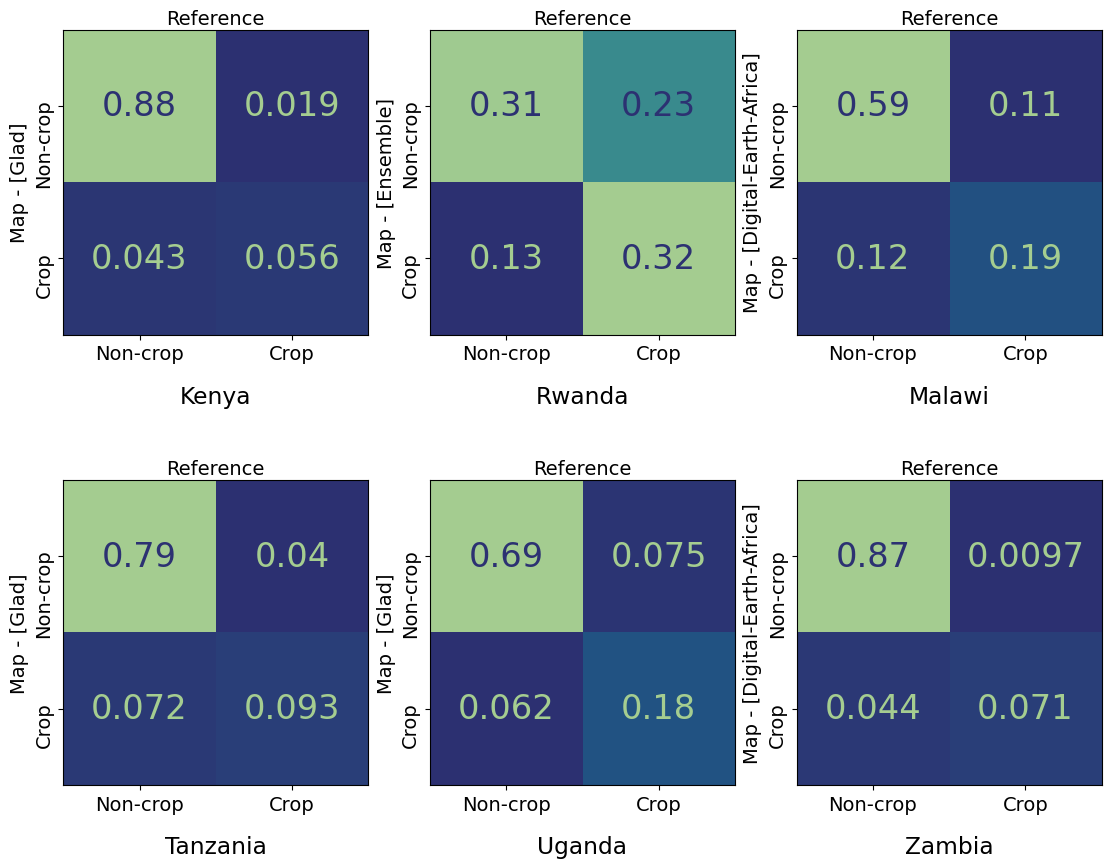

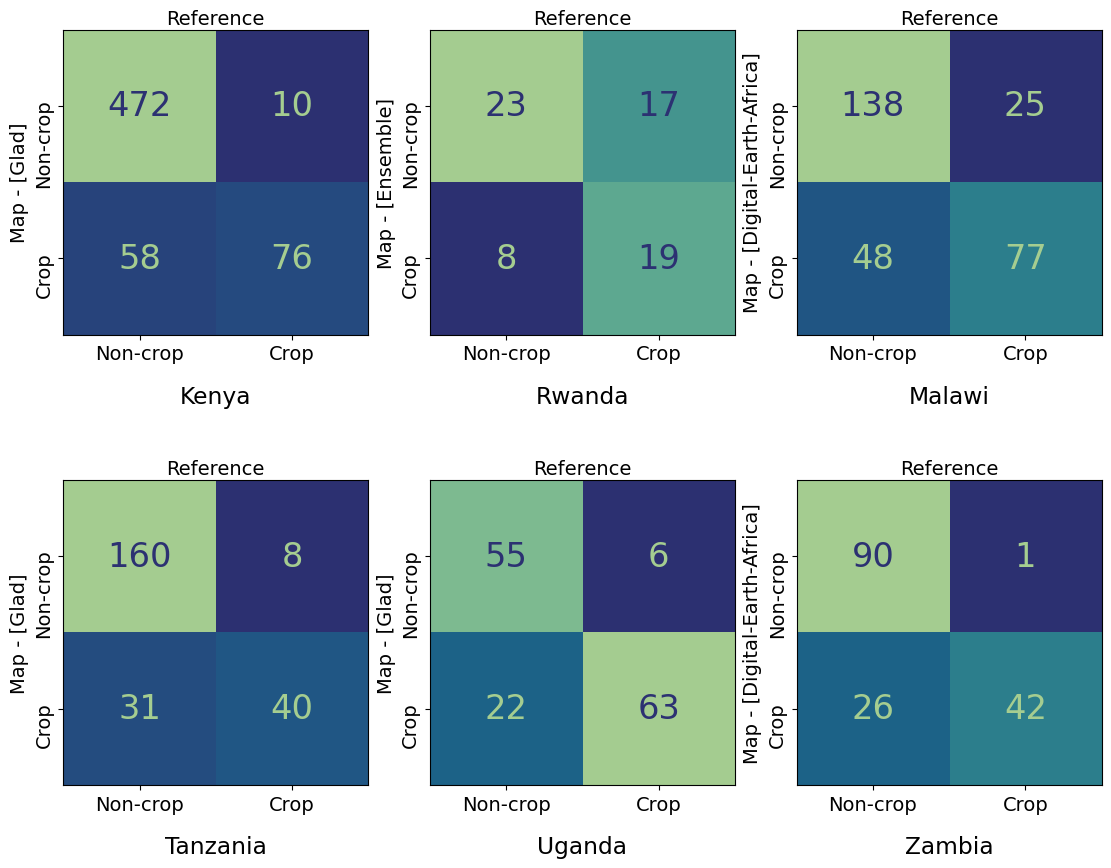

In [93]:
# Generate plots
plot_error_matrices(
    countries,
    area_map_df,
    area_ref_samples,
    a_j,
    save_path='area_error_matrices.pdf'
)

plot_error_matrices(
    countries,
    area_map_df,
    area_ref_samples,
    a_j,
    area_proportion=False,
    save_path='error_matrices.pdf'
)

In [94]:
#@title Plot Relative efficiency
def compute_relative_efficiency(n_opts):
    """Compute relative efficiency matrix between sample sizes."""
    n = len(n_opts)
    rel_eff = np.zeros((n, n))
    for i, nA in enumerate(n_opts):
        for j, nB in enumerate(n_opts):
            rel_eff[i, j] = nB / nA
    return rel_eff

def plot_relative_efficiency_heatmap(ax, rel_eff_df, country, f, show_cbar=False):
    """Plot relative efficiency heatmap for a single country."""
    sns.heatmap(
        rel_eff_df,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        ax=ax,
        cbar_kws={'label': 'Relative efficiency'} if show_cbar else None
    )
    ax.set_title(f"{country} $f={f:.2f}$")

def setup_axis_labels(ax, row, col, n_rows, n_cols):
    """Setup axis labels based on position in subplot grid."""
    # Y-label only on first column
    if col == 0:
        ax.set_ylabel("Map A")
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])
        ax.yaxis.set_visible(False)

    # X-label only on bottom row
    if row == n_rows - 1:
        ax.set_xlabel("Map B")
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])
        ax.xaxis.set_visible(False)


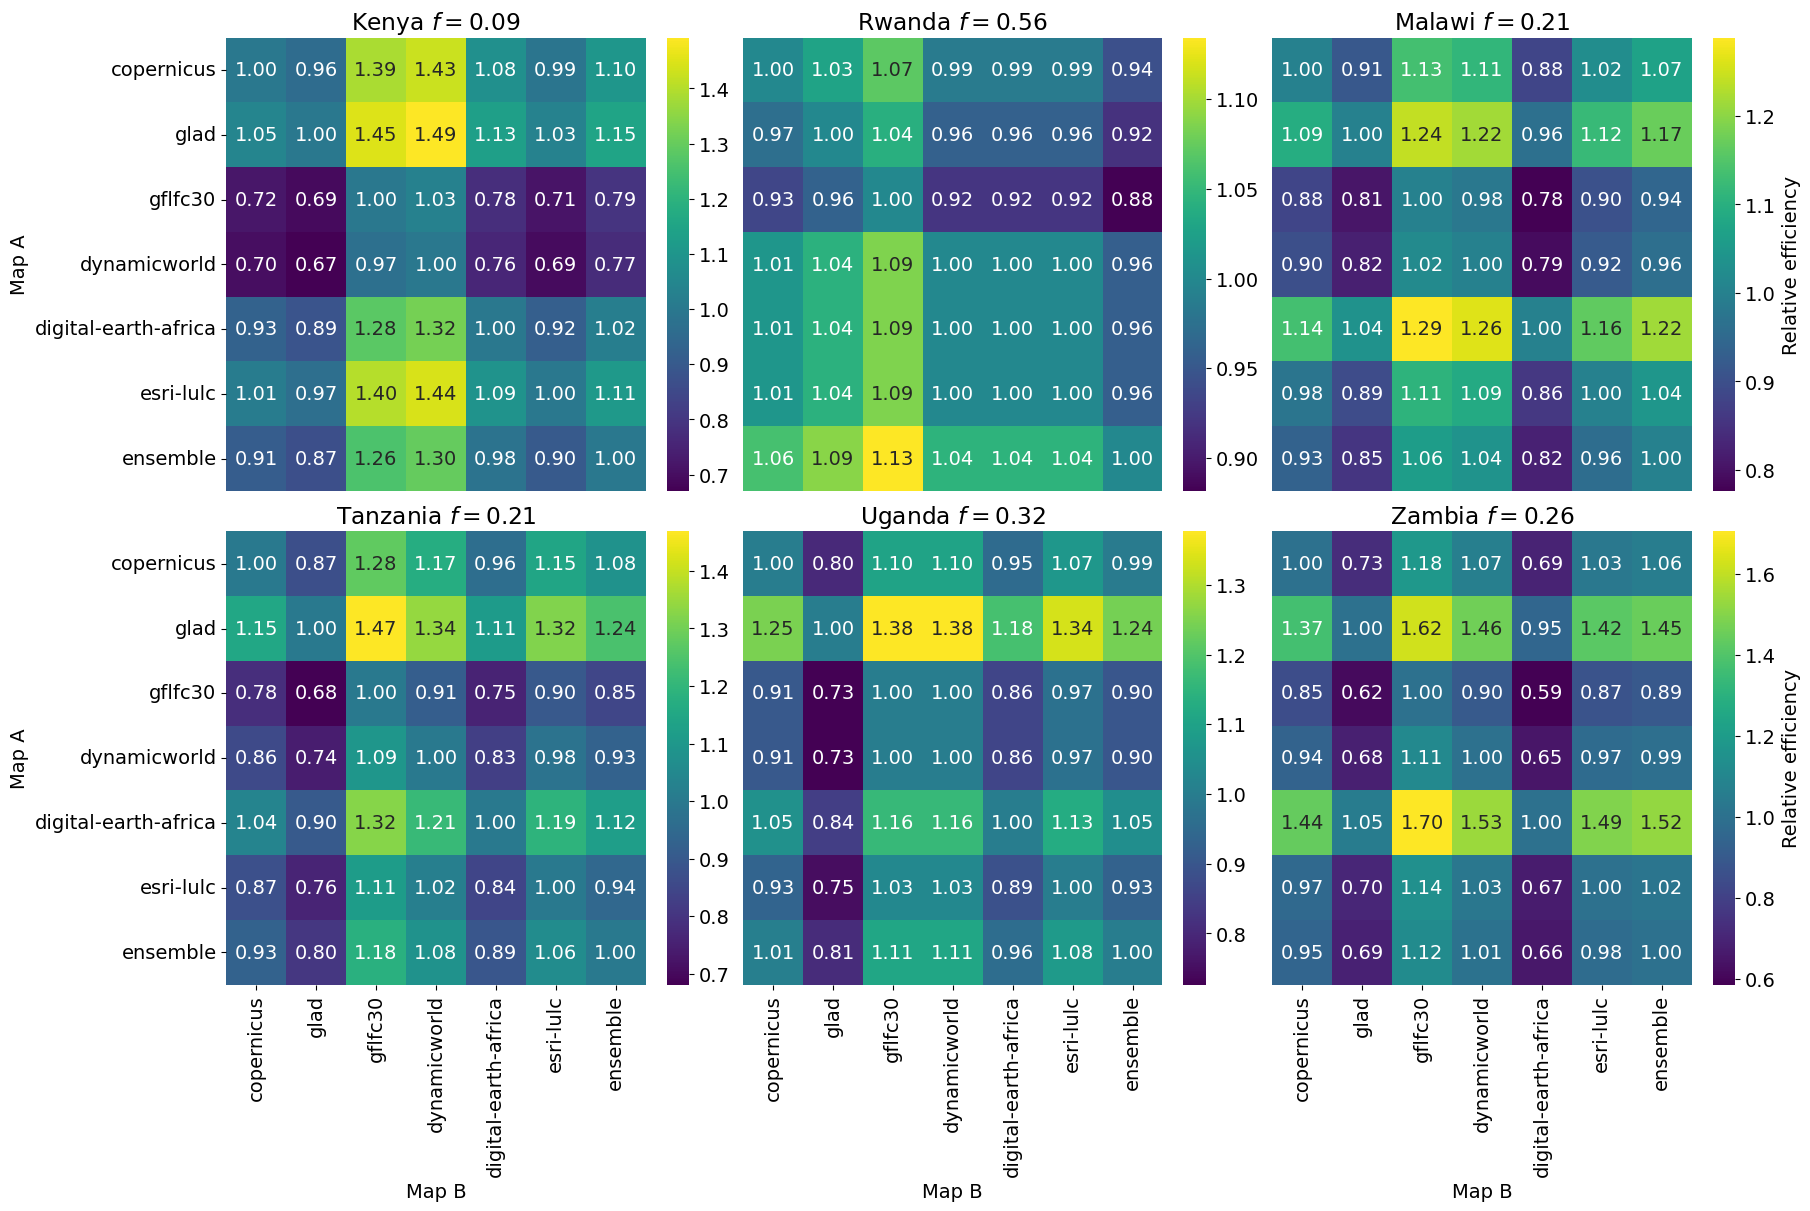

In [95]:
# Rel. eff. plots
plt.rcParams.update({'font.size': 14})
n_rows, n_cols = 2, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12), constrained_layout=True)
axes = axes.reshape(n_rows, n_cols)

for idx, country in enumerate(countries):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col]

    # Get data for current country
    df = df_params[df_params['country'] == country]
    datasets = df['dataset'].tolist()
    n_opts = df['n_opt'].values
    f = df['f'].values[0]

    # Compute and plot relative efficiency
    rel_eff = compute_relative_efficiency(n_opts)
    rel_eff_df = pd.DataFrame(rel_eff, index=datasets, columns=datasets)
    plot_relative_efficiency_heatmap(ax, rel_eff_df, country, f, show_cbar=(col == n_cols - 1))
    setup_axis_labels(ax, row, col, n_rows, n_cols)

for idx in range(len(countries), n_rows * n_cols):
    fig.delaxes(axes.flatten()[idx])

# plt.savefig('relative_efficiency.pdf', dpi=600, transparent=None, facecolor='w', bbox_inches='tight')
plt.show()


In [96]:
## Efficiency gain
# 1. Find min and max n_opt for each country
idx_min = df_params.groupby('country')['n_opt'].idxmin()
df_min = df_params.loc[idx_min][['country', 'dataset', 'n_opt']].rename(
    columns={'dataset': 'most_efficient_map', 'n_opt': 'n_most_efficient'}
)

# Find the index of the row with the maximum n_opt for each country
idx_max = df_params.groupby('country')['n_opt'].idxmax()
df_max = df_params.loc[idx_max][['country', 'dataset', 'n_opt']].rename(
    columns={'dataset': 'least_efficient_map', 'n_opt': 'n_least_efficient'}
)

# 2. Merge min and max info into a summary table
df_summary = pd.merge(df_min, df_max, on='country')

# 3. Absolute number of points fewer (saved)
df_summary['points_saved'] = df_summary['n_least_efficient'] - df_summary['n_most_efficient']

# Percentage of points saved
df_summary['percent_saved'] = (df_summary['points_saved'] / df_summary['n_least_efficient']) * 100

df_summary = df_summary.set_index('country')
df_summary

,most_efficient_map,n_most_efficient,least_efficient_map,n_least_efficient,points_saved,percent_saved
country,,,,,,
Kenya,glad,616,dynamicworld,919,303,32.970620
Malawi,digital-earth-africa,288,gflfc30,371,83,22.371968
Rwanda,ensemble,67,gflfc30,76,9,11.842105
Tanzania,glad,239,gflfc30,351,112,31.908832
Uganda,glad,146,gflfc30,201,55,27.363184
Zambia,digital-earth-africa,159,gflfc30,271,112,41.328413


In [97]:
#@title plot area comparison

from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

@dataclass
class PlotConfig:
    """Configuration for bar plot visualization."""
    bar_width: float = 0.2 # Increased bar width
    group_spacing: float = 0.35
    alpha: float = 0.7
    error_kw: Dict = None

    def __post_init__(self):
        if self.error_kw is None:
            self.error_kw = {'ecolor': '0.3', 'capsize': 3, 'capthick': 1}

@dataclass
class LegendConfig:
    """Configuration for plot legend."""
    labels: List[str] = None
    colors: List[str] = None

    def __post_init__(self):
        if self.labels is None:
            self.labels = ['Sample-based', 'Pixel-count', 'FAOSTAT Cropland',
                          'FAOSTAT Arable land', 'USDA-FAS', 'Official']
        if self.colors is None:
            self.colors = ['#1b9e77', '#66c2a5', '#7570b3', '#d95f02',
                          '#e7298a', '#666666']

plt.rcParams.update({'font.size': 14})

def setup_figure(country: Optional[str], num_countries: int) -> Tuple[plt.Figure, List[plt.Axes]]:
    """Create figure and axes based on number of countries."""
    if country:
        fig, axs = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True)
        return fig, [axs]

    fig = plt.figure(figsize=(16, 6), constrained_layout=True)
    gs = gridspec.GridSpec(2, 3, figure=fig)
    axs = []
    for i in range(num_countries):
        if i < 6:
            ax = fig.add_subplot(gs[i // 3, i % 3])
        else:
            ax = fig.add_subplot(gs[2, 1])
        axs.append(ax)
    return fig, axs

def plot_bar(ax: plt.Axes, x: float, y: float, color: str,
            config: PlotConfig, yerr: Optional[float] = None) -> None:
    """Plot a single bar with optional error bars."""
    if yerr is not None:
        ax.bar(x, y, yerr=yerr, width=config.bar_width, color=color,
               error_kw=config.error_kw, alpha=config.alpha)
    else:
        ax.bar(x, y, width=config.bar_width, color=color, alpha=config.alpha)

def format_y_axis(ax: plt.Axes, country: str) -> None:
    """Format y-axis based on country."""
    if country == 'Rwanda':
        ax.get_yaxis().set_major_formatter(
            plt.FuncFormatter(lambda x, loc: "{:.1f}".format(x / 1e6)))
    else:
        ax.get_yaxis().set_major_formatter(
            plt.FuncFormatter(lambda x, loc: "{:.1f}".format(int(x / 1e6))))

def plot_results_country_bar(land_cover: pd.DataFrame, survey_stats: pd.DataFrame,
                           country: Optional[str] = None) -> None:
    """Plot bar charts comparing different land area estimates by country."""
    config = PlotConfig()
    legend_config = LegendConfig()
    label_to_color = dict(zip(legend_config.labels, legend_config.colors))

    all_countries = land_cover['country'].unique()
    countries = [country] if country else all_countries
    num_countries = len(countries)

    fig, axs = setup_figure(country, num_countries)
    max_xpos = 0

    for i, c in enumerate(countries):
        ax = axs[i]
        lc = land_cover[land_cover['country'] == c]
        sy = survey_stats[survey_stats['country'] == c]

        # Filter survey data
        fao_cp = sy[sy['Item'] == 'Cropland']
        fao_ar = sy[sy['Item'] == 'Arable land']
        usda = sy[sy['Item'] == 'USDA-FAS']
        official = sy[sy['Item'] == 'Official-Cropland']

        x_positions = {}
        xpos = 0.0

        # Plot Sample-based & Pixel-count
        if not lc.empty:
            x_positions['Sample-based'] = xpos
            x_positions['Pixel-count'] = xpos + config.bar_width
            plot_bar(ax, x_positions['Sample-based'], lc['f_ha'].values[0],
                    label_to_color['Sample-based'], config, lc['se_ha'].values[0])
            plot_bar(ax, x_positions['Pixel-count'], lc['px_ha'].values[0],
                    label_to_color['Pixel-count'], config)
            xpos += 2 * config.bar_width + config.group_spacing

        # Plot FAO data
        if not fao_cp.empty or not fao_ar.empty:
            if not fao_cp.empty:
                x_positions['FAOSTAT Cropland'] = xpos
                plot_bar(ax, xpos, fao_cp['Area Kha'].values[0],
                        label_to_color['FAOSTAT Cropland'], config)
                xpos += config.bar_width
            if not fao_ar.empty:
                x_positions['FAOSTAT Arable land'] = xpos
                plot_bar(ax, xpos, fao_ar['Area Kha'].values[0],
                        label_to_color['FAOSTAT Arable land'], config)
                xpos += config.bar_width
            xpos += config.group_spacing

        # Plot USDA-FAS
        if not usda.empty:
            x_positions['USDA-FAS'] = xpos
            plot_bar(ax, xpos, usda['Area Kha'].values[0],
                    label_to_color['USDA-FAS'], config)
            xpos += config.bar_width + config.group_spacing

        # Plot Official
        if not official.empty:
            x_positions['Official'] = xpos
            plot_bar(ax, xpos, official['Area Kha'].values[0],
                    label_to_color['Official'], config)
            xpos += config.bar_width + config.group_spacing

        max_xpos = max(max_xpos, xpos)

        # Format axes
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_ylabel(c)
        format_y_axis(ax, c)
        ax.grid(axis='y', linestyle='--', alpha=0.6)

    # Set consistent xlim and add legend
    for ax in axs:
        ax.set_xlim(-0.2, max_xpos)

    handles = [axs[0].bar(0, 0, color=color, label=label, alpha=config.alpha)
              for label, color in zip(legend_config.labels, legend_config.colors)]
    fig.legend(handles=handles, loc='lower center', ncol=3)

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.savefig('per_country_bar.pdf', dpi=600, transparent=None, facecolor='w', bbox_inches='tight')
    plt.show()

/tmp/ipython-input-3490390617.py:152: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.1, 1, 1])


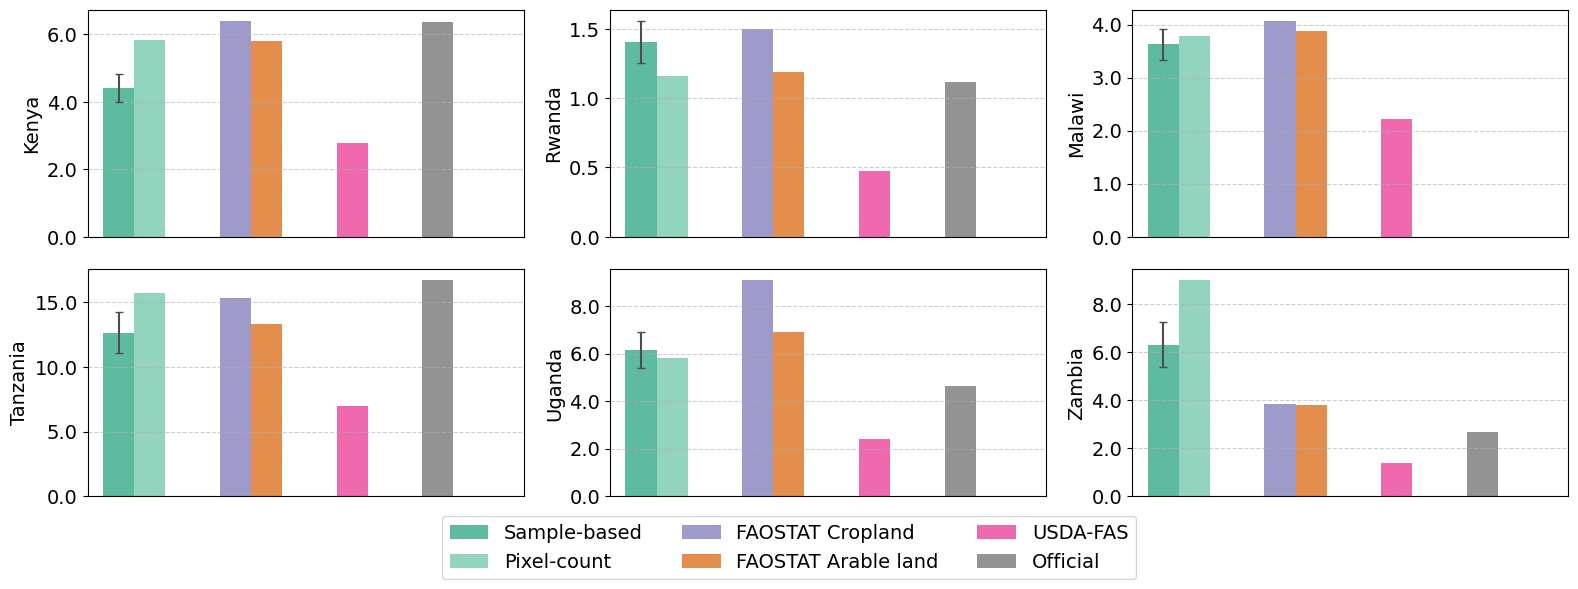

In [98]:
survey_stats = pd.read_csv('./data/land_use_data.csv').drop(columns=['source'])
plot_results_country_bar(area_results, survey_stats)